# Euro-Cordex data processing at DKRZ

In [98]:
import dask
import fsspec
import intake
import numpy as np

# import seaborn as sns
import pandas as pd
import xarray as xr
from dask.diagnostics import progress
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dask.__version__

'2021.04.0'

In [99]:
from dask.distributed import Client

client = Client()
client

/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33564 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:35000 Dashboard: /user/g300046/advanced//proxy/33564/status,Cluster Workers: 8 Cores: 48 Memory: 248.44 GiB


In [100]:
!ls /work/kd0956/Catalogs/

archive		      mistral-cordex.csv.gz  mistral-era5.json
mistral-cmip5.csv.gz  mistral-cordex.json
mistral-cmip5.json    mistral-era5.csv.gz


In [101]:
import intake

url = "/work/kd0956/Catalogs/mistral-cordex.json"
cat = intake.open_esm_datastore(url)
cat

,unique
product_id,2
CORDEX_domain,23
institute_id,69
driving_model_id,13
experiment_id,5
member,5
model_id,28
rcm_version_id,5
frequency,7
variable_id,104


In [179]:
expts = ["historical", "rcp26", "rcp85"]
# search = cat.search(variable_id='tas', frequency='mon', CORDEX_domain='EUR-11', member='r1i1p1', experiment_id=expts, require_all_on=['model_id', 'driving_model_id'])
search = cat.search(
    variable_id="tas",
    frequency="mon",
    CORDEX_domain="EUR-11",
    model_id="GERICS-REMO2015",
    institute_id="GERICS",
    member="r1i1p1",
)
search.df.groupby(["model_id", "driving_model_id", "institute_id"])[
    "experiment_id"
].nunique()

model_id         driving_model_id       institute_id
GERICS-REMO2015  CNRM-CERFACS-CNRM-CM5  GERICS          3
                 ECMWF-ERAINT           GERICS          1
                 ICHEC-EC-EARTH         GERICS          1
                 IPSL-IPSL-CM5A-LR      GERICS          2
                 IPSL-IPSL-CM5A-MR      GERICS          2
                 MIROC-MIROC5           GERICS          1
                 MOHC-HadGEM2-ES        GERICS          2
                 NCC-NorESM1-M          GERICS          4
                 NOAA-GFDL-GFDL-ESM2G   GERICS          2
Name: experiment_id, dtype: int64

In [180]:
dsets = search.to_dataset_dict(cdf_kwargs={"use_cftime": True, "chunks": {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency'


In [181]:
dsets.keys()

dict_keys(['EUR-11.ECMWF-ERAINT.GERICS.GERICS-REMO2015.evaluation.mon', 'EUR-11.IPSL-IPSL-CM5A-LR.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.IPSL-IPSL-CM5A-MR.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.CNRM-CERFACS-CNRM-CM5.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.IPSL-IPSL-CM5A-MR.GERICS.GERICS-REMO2015.rcp85.mon', 'EUR-11.MOHC-HadGEM2-ES.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.MIROC-MIROC5.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.rcp45.mon', 'EUR-11.IPSL-IPSL-CM5A-LR.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.ICHEC-EC-EARTH.GERICS.GERICS-REMO2015.rcp45.mon', 'EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.CNRM-CERFACS-CNRM-CM5.GERICS.GERICS-REMO2015.rcp85.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.rcp85.mon', 

In [182]:
# dsets['EUR-11.MOHC-HadGEM2-ES.KNMI.KNMI-RACMO22E.historical.mon'].tas.dims[-2:]

In [183]:
%matplotlib inline
from datetime import datetime as dt

for key, ds in dsets.items():
    ds.coords["time"] = [dt(date.year, date.month, 15) for date in ds.time.values]
dsets = {key: ds.sortby("time") for key, ds in dsets.items()}

In [184]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds if (("bounds") in vname) or ("bnds") in vname]
    return ds.drop(drop_vars)


def get_lat_name(ds):
    for lat_name in ["rlat", "y", "lat", "latitude"]:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def get_lon_name(ds):
    for lon_name in ["rlon", "x", "lon", "longitude"]:
        if lon_name in ds.coords:
            return lon_name
    raise RuntimeError("Couldn't find a longitude coordinate")


def global_mean(ds):
    """weighted spatial global mean"""
    ds = drop_all_bounds(ds)
    # lat_name = get_lat_name(ds)
    # lon_name = get_lon_name(ds)
    # lat = ds[get_lat_name(ds)]
    # weight = np.cos(np.deg2rad(lat))
    # weight /= weight.mean()
    dims = ds.tas.dims[-2:]
    return (ds).mean(dim=(dims))

In [188]:
from collections import defaultdict

dsets_dict = defaultdict(dict)

keys = "CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency".split(
    "."
)

from tqdm.autonotebook import tqdm

dsets_mean = {}

for key, ds in tqdm(dsets.items()):
    attrs = dict(zip(keys, [[attr] for attr in key.split(".")]))
    dsets_mean[key] = global_mean(ds.expand_dims(attrs))

  0%|          | 0/18 [00:00<?, ?it/s]

In [151]:
ds_means = [
    dsets_mean["EUR-11.MOHC-HadGEM2-ES.KNMI.KNMI-RACMO22E.historical.mon"].tas,
    dsets_mean["EUR-11.MOHC-HadGEM2-ES.KNMI.KNMI-RACMO22E.rcp26.mon"].tas,
    dsets_mean["EUR-11.MOHC-HadGEM2-ES.KNMI.KNMI-RACMO22E.rcp85.mon"].tas,
    dsets_mean["EUR-11.CNRM-CERFACS-CNRM-CM5.GERICS.GERICS-REMO2015.rcp26.mon"].tas,
]

combined = xr.combine_by_coords(ds_means)

/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = fu

In [189]:
dsets_mean.keys()

dict_keys(['EUR-11.ECMWF-ERAINT.GERICS.GERICS-REMO2015.evaluation.mon', 'EUR-11.IPSL-IPSL-CM5A-LR.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.IPSL-IPSL-CM5A-MR.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.CNRM-CERFACS-CNRM-CM5.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.IPSL-IPSL-CM5A-MR.GERICS.GERICS-REMO2015.rcp85.mon', 'EUR-11.MOHC-HadGEM2-ES.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.MIROC-MIROC5.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.rcp45.mon', 'EUR-11.IPSL-IPSL-CM5A-LR.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.ICHEC-EC-EARTH.GERICS.GERICS-REMO2015.rcp45.mon', 'EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.rcp26.mon', 'EUR-11.CNRM-CERFACS-CNRM-CM5.GERICS.GERICS-REMO2015.rcp85.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.rcp85.mon', 

In [195]:
combined = xr.combine_by_coords([ds.tas for ds in dsets_mean.values()])

/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = fu

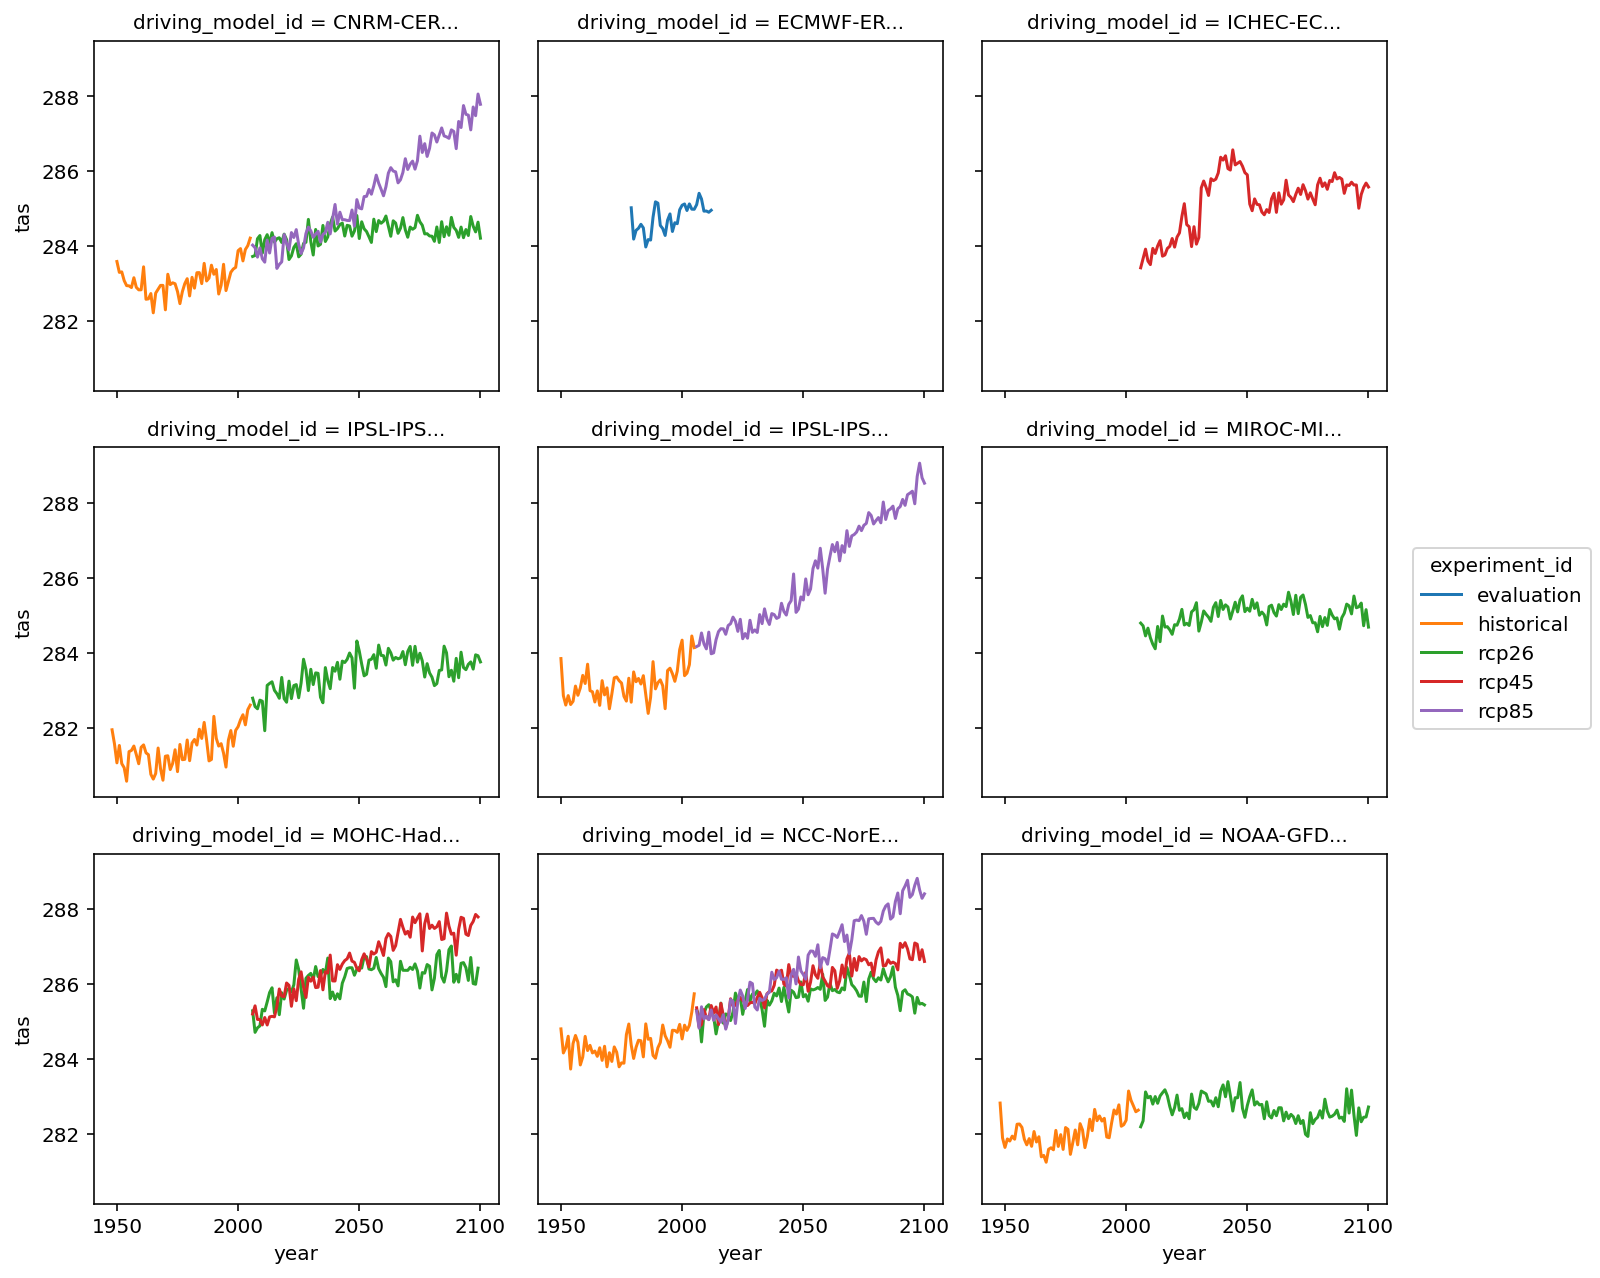

In [198]:
combined.tas.groupby("time.year").mean(dim="time").plot(
    x="year", hue="experiment_id", col="driving_model_id", col_wrap=3
)

In [152]:
dsets_mean["EUR-11.CNRM-CERFACS-CNRM-CM5.GERICS.GERICS-REMO2015.rcp26.mon"].tas

,Array,Chunk
Bytes,4.45 kiB,480 B
Shape,"(1, 1, 1, 1, 1, 1, 1, 1140)","(1, 1, 1, 1, 1, 1, 1, 120)"
Count,80 Tasks,10 Chunks
Type,float32,numpy.ndarray


In [167]:
combined

,Array,Chunk
Bytes,169.88 kiB,68.62 kiB
Shape,"(1, 2, 2, 2, 3, 1, 1, 1812)","(1, 2, 2, 2, 3, 1, 1, 732)"
Count,665 Tasks,10 Chunks
Type,float32,numpy.ndarray


In [161]:
data = combined.tas.sel(experiment_id="rcp26").groupby("time.year").mean(dim="time")
data

,Array,Chunk
Bytes,4.72 kiB,32 B
Shape,"(1, 2, 2, 2, 1, 1, 151)","(1, 2, 2, 2, 1, 1, 1)"
Count,1430 Tasks,151 Chunks
Type,float32,numpy.ndarray


In [62]:
import numpy as np
import xarray as xr

data = xr.DataArray([1, 2, 3], dims="x", coords={"x": [10, 20, 30]})
data

<xarray.DataArray (x: 3)>
array([1, 2, 3])
Coordinates:
  * x        (x) int64 10 20 30

In [61]:
data_newcoord = data.assign_coords(y="coord_value")
data_expanded = data_newcoord.expand_dims("y")
data_expanded

<xarray.DataArray (y: 1, x: 3)>
array([[1, 2, 3]])
Coordinates:
  * x        (x) int64 10 20 30
  * y        (y) <U11 'coord_value'

In [184]:
remo = "/pool/data/CORDEX/data/cordex/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r0i0p0/GERICS-REMO2015/v1/fx/orog/v20180813/orog_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx.nc"
aladin = "/pool/data/CORDEX/data/cordex/output/EUR-11/CNRM/CNRM-CERFACS-CNRM-CM5/historical/r1i1p1/CNRM-ALADIN53/v1/mon/tas/v20150127/tas_EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_CNRM-ALADIN53_v1_mon_195001-195012.nc"

In [189]:
import xesmf as xe

rds = xr.open_dataset(remo)
ads = xr.open_dataset(aladin)

In [191]:
ads

<xarray.Dataset>
Dimensions:            (tbnds: 2, time: 12, x: 453, y: 453)
Coordinates:
    lon                (y, x) float64 ...
    lat                (y, x) float64 ...
    height             float64 ...
  * time               (time) datetime64[ns] 1950-01-16T12:00:00 ... 1950-12-...
  * x                  (x) float64 0.0 12.5 25.0 ... 5.638e+03 5.65e+03
  * y                  (y) float64 0.0 12.5 25.0 ... 5.638e+03 5.65e+03
Dimensions without coordinates: tbnds
Data variables:
    tas                (time, y, x) float32 ...
    Lambert_Conformal  |S1 ...
    time_bnds          (time, tbnds) datetime64[ns] ...
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.6.8 (htt...
    Conventions:                    CF-1.4
    institution:                    Centre National de Recherches Meteorologi...
    experiment_id:                  historical
    experiment:                     Historical run with GCM forcing
    driving_model_ensemble_member:  r1i1p1
    ...                             ...
    comment:                        CORDEX Europe ALADIN5.3 0.5 deg CNRM-CERF...
    contact:                        contact.aladin-cordex@meteo.fr
    frequency:                      mon
    driving_experiment:             CNRM-CERFACS-CNRM-CM5, historical, r1i1p1
    driving_model_id:               CNRM-CERFACS-CNRM-CM5
    model_id:                       ALADIN53

In [192]:
regridder = xe.Regridder(ads, rds, "bilinear")

In [193]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False

In [195]:
ads_regrid = regridder(ads.tas)

/work/ch0636/g300046/conda_envs/cmip6-processing/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


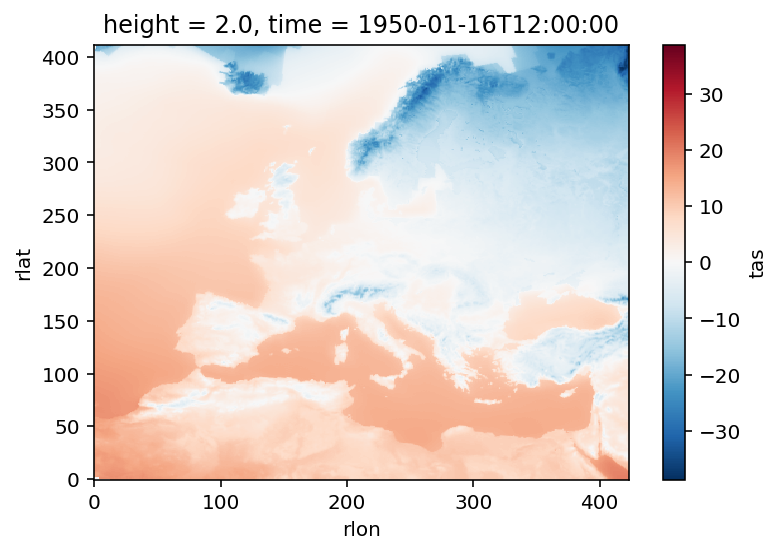

In [197]:
ads_regrid[0].plot()